# ARIMA

### Get a Time Series to analyze

In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
import random
import pandas as pd
%matplotlib inline

df = sns.load_dataset('flights')

In [2]:
NYcrime = pd.read_csv('NYPD_Complaint_Data_Current_YTD.csv')

In [3]:
NYcrime2=NYcrime.groupby(['CMPLNT_FR_DT']).size().reset_index(name='counts')

In [4]:
NYcrime2['YEAR'] = NYcrime2.CMPLNT_FR_DT.str[-4:]

In [5]:
NYcrime2['YEAR'] = pd.to_numeric(NYcrime2['YEAR']) 

In [6]:
NYcrime3 = NYcrime2[NYcrime2.YEAR == 2016]

In [7]:
NYcrime3['Datetime'] = pd.to_datetime(NYcrime3['CMPLNT_FR_DT'])

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
NYcrime4 = NYcrime3[['Datetime','counts']]

In [9]:
NYcrime5=NYcrime4.reset_index()

In [10]:
NYcrime5=NYcrime5.drop(['index'], axis=1)

In [11]:
NYcrime5

,Datetime,counts
0,2016-01-01,2077
1,2016-01-02,1181
2,2016-01-03,1072
3,2016-01-04,1086
4,2016-01-05,1040
...,...,...
269,2016-09-26,1090
270,2016-09-27,1112
271,2016-09-28,1149
272,2016-09-29,1048


C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


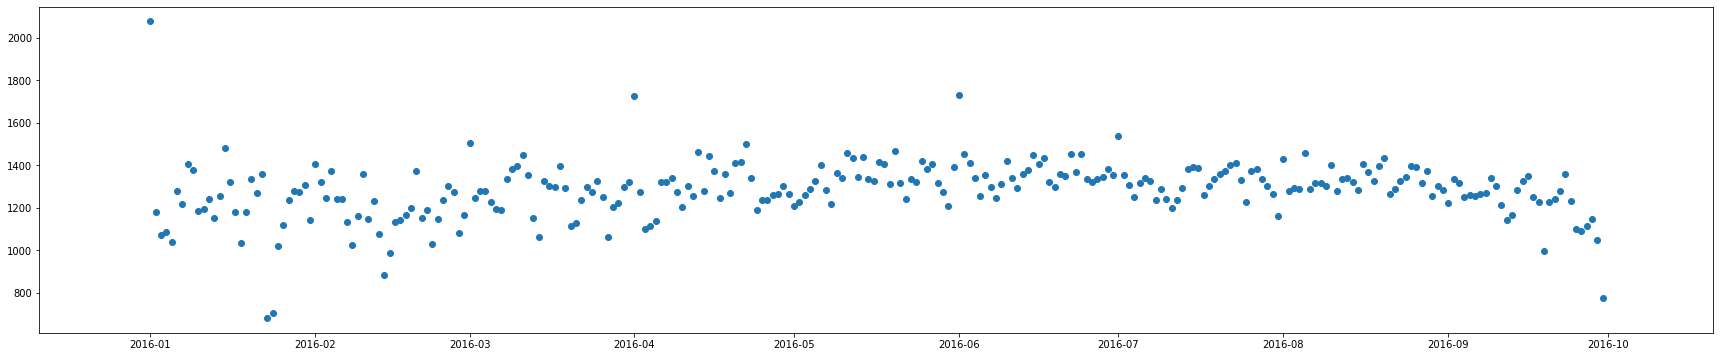

In [12]:
plt.rcParams['figure.figsize'] = (30,6)
plt.scatter(NYcrime5['Datetime'], NYcrime5['counts'])

## ARIMA models require the data to be stationary

1. Non-seasonal
2. Without a trend

**We want to exclude autocorrelation**. We call a non-autocorrelated time series **stationary**.

### Autocorrelation
correlation for each time shift -> ACF plot

if the ACF plot drops quickly to near-zero, you have neither a trend nor seasonality

In [13]:
NYcrime5

,Datetime,counts
0,2016-01-01,2077
1,2016-01-02,1181
2,2016-01-03,1072
3,2016-01-04,1086
4,2016-01-05,1040
...,...,...
269,2016-09-26,1090
270,2016-09-27,1112
271,2016-09-28,1149
272,2016-09-29,1048


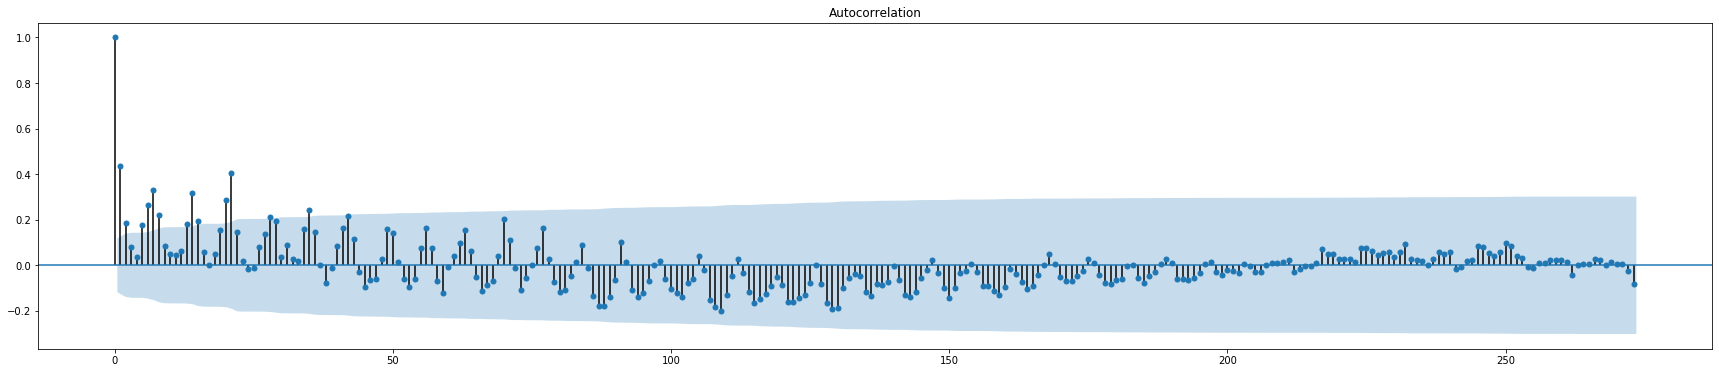

In [14]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(NYcrime5['counts'], lags=273)
None

### Autoregressive Model

p - hyperparameter: how many periods we look into the past

AR(p):

$y_t = c + a_1 y_{t-1} + a_2 y_{t-2} .. + a_p y_{t-p} + \epsilon_t$

In [15]:
import math
# generate data (200 periods) using an AR(2) process
# with parameters: c= 8, w1= 1.3, w2=-0.7
random.seed(42)

data = NYcrime5.counts
c = 8.0
a1 = 1.3
a2 = -0.7

#for i in range(243):
#    # math.sin(10*i) * 
#    yt = c + a1 * data[-1] + a2 * data[-2] + random.gauss(mu=0.0, sigma=1.0)
#   data.append(yt)

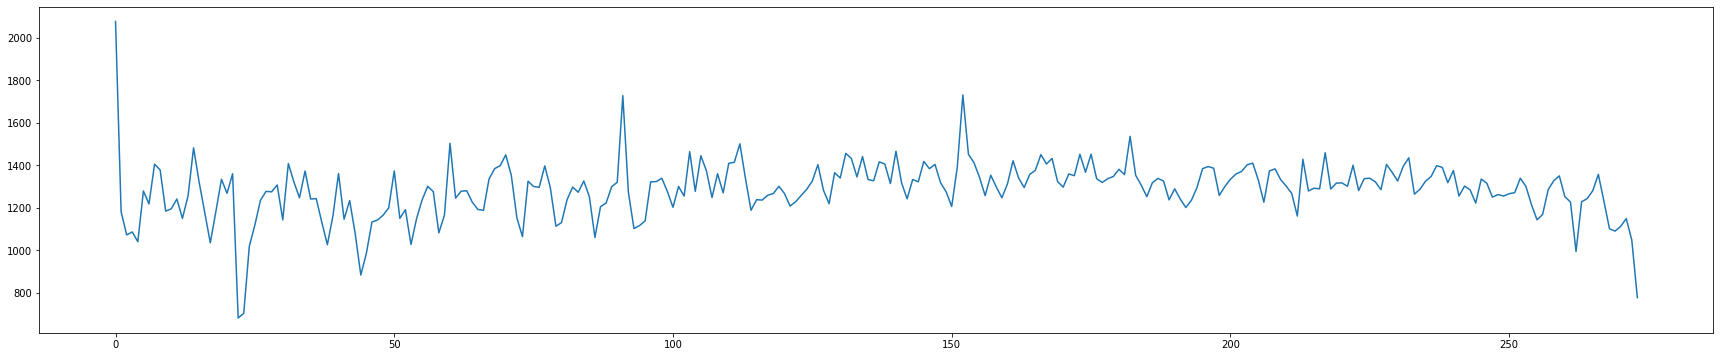

In [16]:
plt.plot(range(274), data)

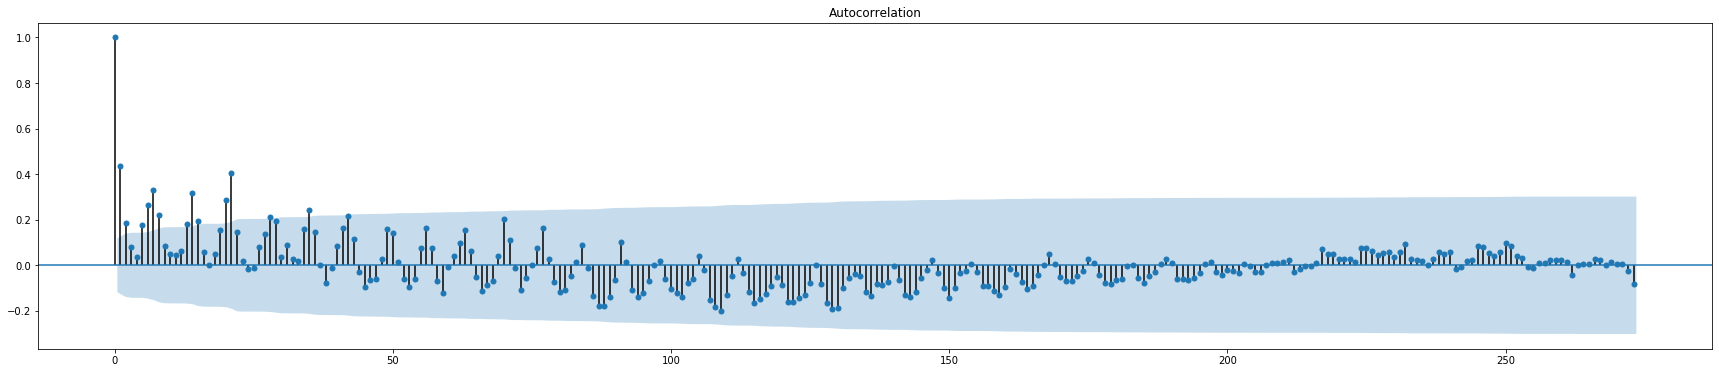

In [17]:
plot_acf(data, lags=273)
None

### Initialize and fit an ARIMA model

also see: Seasonal Arima (SARIMAX)

In [18]:
from statsmodels.tsa.arima_model import ARIMA
import numpy as np

In [19]:
data = NYcrime5.counts
y_train = NYcrime5[NYcrime5.index < 243].counts
y_test = NYcrime5[NYcrime5.index >= 243].counts   # test set is always the last part of your data

In [20]:
# (ar, d, ma) <- Order of the ARIMA model
#                (usually small numbers)
# ar - autoregressive part (0 to 3)
#  d - differencing (0 or 1)
# ma - moving average part (Moving Average of the residuals!!, 0 to 3)
m = ARIMA(y_train, (3, 1, 1))
m.initialize()
r = m.fit()

In [21]:
r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.counts   No. Observations:                  242
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -1495.212
Method:                       css-mle   S.D. of innovations            116.169
Date:                Wed, 29 Apr 2020   AIC                           3002.423
Time:                        18:07:23   BIC                           3023.357
Sample:                             1   HQIC                          3010.856
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3975      0.521      0.762      0.446      -0.625       1.420
ar.L1.D.counts     0.4016      0.077      5.249      0.000       0.252       0.552
ar.L2.D.counts    -0.1099      0.078     -1.408      0.159      -0.263       0.043
ar.L3.D.counts    -0.1463      0.076     -1.928      0.054      -0.295       0.002
ma.L1.D.counts    -0.9479      0.033    -29.045      0.000      -1.012      -0.884
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9757           -1.2558j            1.5902           -0.1449
AR.2            0.9757           +1.2558j            1.5902            0.1449
AR.3           -2.7025           -0.0000j            2.7025           -0.5000
MA.1            1.0549           +0.0000j            1.0549            0.0000
-----------------------------------------------------------------------------
"""

In [22]:
r.aic

3002.423473009235

In [23]:
# prediction for future periods (xtest)
ypred, err, conf = r.forecast(steps=3) # predicted, error, confidence
ypred.shape

(3,)

In [24]:
r.params

const             0.397482
ar.L1.D.counts    0.401603
ar.L2.D.counts   -0.109912
ar.L3.D.counts   -0.146317
ma.L1.D.counts   -0.947945
dtype: float64

In [25]:
fc = []
for i in range(31):
    # reinialize the model
    ytrain = data[:243 + i]
    m = ARIMA(ytrain, (3, 1, 1))
    m.initialize()
    r = m.fit()
    # do a forecast 3 periods ahead
    ypred, err, conf = r.forecast(steps=31) # predicted, error, confidence
    # collect the last forecasted point
    fc.append(ypred[0])

In [26]:
fc

[1331.1492452182522,
 1333.9236718115567,
 1297.3363231759126,
 1354.8860167593436,
 1341.393198176319,
 1295.5807771451653,
 1308.3544108462074,
 1310.052759030291,
 1310.6280256215632,
 1309.7797418132157,
 1337.3287870266677,
 1311.5454176274359,
 1264.5364861497453,
 1240.9135637206366,
 1265.3146051090523,
 1322.1181244539068,
 1322.6684393048233,
 1312.430306772637,
 1258.8744605515724,
 1253.8170747160668,
 1154.7500036199299,
 1284.8317571882865,
 1299.2107474340562,
 1271.6763502240428,
 1303.8430327467975,
 1233.242567719784,
 1170.6043492520569,
 1193.5391026086047,
 1216.7424330024187,
 1223.047853537609,
 1155.5532634072367]

In [27]:
ypred

array([1155.55326341, 1202.28299457, 1225.18846634, 1210.83980501,
       1194.62922718, 1185.74097904, 1186.10681672, 1189.59784327,
       1192.07880151, 1192.2847415 , 1191.19273102, 1190.01062964,
       1189.31363237, 1189.03182256, 1188.87409658, 1188.63874957,
       1188.29046565, 1187.8859254 , 1187.48467394, 1187.10964205,
       1186.75384692, 1186.4021505 , 1186.04559048, 1185.68348338,
       1185.31906003, 1184.95514758, 1184.59261051, 1184.23093995,
       1183.86937245, 1183.50752168, 1183.1454049 ])

(array([736194.]), array([736224.]))

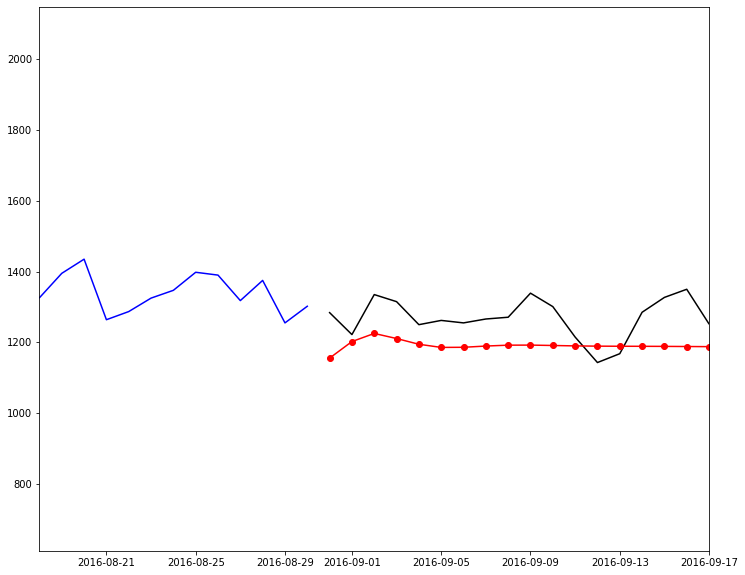

In [28]:
plt.figure(figsize=(12, 10))
plt.plot(NYcrime5[NYcrime5.index < 243].Datetime, y_train, color='blue')
plt.plot(NYcrime5[NYcrime5.index >= 243].Datetime, y_test, color='black')
plt.plot(NYcrime5[NYcrime5.index >= 243].Datetime, ypred, color='red', marker='o')
plt.xlim(NYcrime5[NYcrime5.index == 230].Datetime,NYcrime5[NYcrime5.index == 260].Datetime)

In [29]:
r.aic

3358.7907609616022

In [30]:
r.params

const            -0.362082
ar.L1.D.counts    0.391311
ar.L2.D.counts   -0.109952
ar.L3.D.counts   -0.165997
ma.L1.D.counts   -0.907110
dtype: float64

In [31]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO


In [32]:
data

0      2077
1      1181
2      1072
3      1086
4      1040
       ... 
269    1090
270    1112
271    1149
272    1048
273     777
Name: counts, Length: 274, dtype: int64

In [33]:
mod = sm.tsa.statespace.SARIMAX(y_train, order=(6,1,4), seasonal_order=(0, 0, 0, 0))
res = mod.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  243
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1480.296
Date:                Wed, 29 Apr 2020   AIC                           2982.592
Time:                        18:07:35   BIC                           3020.971
Sample:                             0   HQIC                          2998.053
                                - 243                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7737      0.131     -5.928      0.000      -1.030      -0.518
ar.L2         -0.9259      0.087    -10.587      0.000      -1.097      -0.755
ar.L3         -0.5212      0.136     -3.820      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [34]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 counts   No. Observations:                  243
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1480.296
Date:                Wed, 29 Apr 2020   AIC                           2982.592
Time:                        18:07:35   BIC                           3020.971
Sample:                             0   HQIC                          2998.053
                                - 243                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7737      0.131     -5.928      0.000      -1.030      -0.518
ar.L2         -0.9259      0.087    -10.587      0.000      -1.097      -0.755
ar.L3         -0.5212      0.136     -3.820      0.000      -0.789      -0.254
ar.L4         -0.3031      0.123     -2.473      0.013      -0.543      -0.063
ar.L5         -0.4306      0.068     -6.329      0.000      -0.564      -0.297
ar.L6         -0.3828      0.064     -6.021      0.000      -0.507      -0.258
ma.L1          0.1881      0.145      1.298      0.194      -0.096       0.472
ma.L2          0.3026      0.116      2.617      0.009       0.076       0.529
ma.L3         -0.3717      0.107     -3.473      0.001      -0.581      -0.162
ma.L4         -0.6054      0.154     -3.925      0.000      -0.908      -0.303
sigma2      1.053e+04    741.965     14.188      0.000    9072.449     1.2e+04
===================================================================================
Ljung-Box (Q):                       88.80   Jarque-Bera (JB):               688.99
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                            -0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
res.aic

2982.592423796454

In [36]:
ypredsari, err, conf = res.forecast(3) # predicted, error, confidence

In [37]:
ypredsari, err, conf

(1296.6904057311, 1305.4615008491535, 1398.5643955319808)

In [38]:
res.params

ar.L1        -0.773723
ar.L2        -0.925941
ar.L3        -0.521151
ar.L4        -0.303122
ar.L5        -0.430596
ar.L6        -0.382781
ma.L1         0.188097
ma.L2         0.302603
ma.L3        -0.371670
ma.L4        -0.605394
sigma2    10526.674300
dtype: float64

In [45]:
fcsari = []
for i in range(31):
    # reinialize the model
    ytrain = data[:243 + i]
    mod = sm.tsa.statespace.SARIMAX(ytrain, order=(6,1,4), seasonal_order=(0, 0, 0, 10))
#    mod.initialize()
    res = mod.fit()
    # do a forecast 3 periods ahead
    ypredsari, err, conf = res.forecast(steps=3) # predicted, error, confidence
    # collect the last forecasted point
    fcsari.append(ypredsari)
    print(res.summary())

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  243
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1480.296
Date:                Wed, 29 Apr 2020   AIC                           2982.592
Time:                        18:11:29   BIC                           3020.971
Sample:                             0   HQIC                          2998.053
                                - 243                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7737      0.131     -5.928      0.000      -1.030      -0.518
ar.L2         -0.9259      0.087    -10.587      0.000      -1.097      -0.755
ar.L3         -0.5212      0.136     -3.820      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  244
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1486.848
Date:                Wed, 29 Apr 2020   AIC                           2995.697
Time:                        18:11:30   BIC                           3034.120
Sample:                             0   HQIC                          3011.173
                                - 244                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8807      0.099     -8.892      0.000      -1.075      -0.687
ar.L2         -0.8755      0.087    -10.109      0.000      -1.045      -0.706
ar.L3         -0.6104      0.119     -5.112      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  245
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1492.235
Date:                Wed, 29 Apr 2020   AIC                           3006.469
Time:                        18:11:32   BIC                           3044.938
Sample:                             0   HQIC                          3021.962
                                - 245                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8418      0.114     -7.382      0.000      -1.065      -0.618
ar.L2         -0.8985      0.088    -10.212      0.000      -1.071      -0.726
ar.L3         -0.5733      0.126     -4.544      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  246
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1497.574
Date:                Wed, 29 Apr 2020   AIC                           3017.148
Time:                        18:11:34   BIC                           3055.662
Sample:                             0   HQIC                          3032.657
                                - 246                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8246      0.108     -7.634      0.000      -1.036      -0.613
ar.L2         -0.8795      0.088    -10.008      0.000      -1.052      -0.707
ar.L3         -0.5236      0.123     -4.256      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  247
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1503.442
Date:                Wed, 29 Apr 2020   AIC                           3028.884
Time:                        18:11:37   BIC                           3067.443
Sample:                             0   HQIC                          3044.410
                                - 247                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8591      0.114     -7.545      0.000      -1.082      -0.636
ar.L2         -0.9004      0.086    -10.429      0.000      -1.070      -0.731
ar.L3         -0.5972      0.124     -4.799      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  248
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1509.435
Date:                Wed, 29 Apr 2020   AIC                           3040.871
Time:                        18:11:38   BIC                           3079.474
Sample:                             0   HQIC                          3056.413
                                - 248                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8577      0.109     -7.842      0.000      -1.072      -0.643
ar.L2         -0.8870      0.086    -10.320      0.000      -1.055      -0.719
ar.L3         -0.5849      0.124     -4.716      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  249
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1515.017
Date:                Wed, 29 Apr 2020   AIC                           3052.035
Time:                        18:11:40   BIC                           3090.683
Sample:                             0   HQIC                          3067.593
                                - 249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8488      0.111     -7.624      0.000      -1.067      -0.631
ar.L2         -0.9048      0.085    -10.622      0.000      -1.072      -0.738
ar.L3         -0.5891      0.125     -4.720      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  250
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1521.318
Date:                Wed, 29 Apr 2020   AIC                           3064.637
Time:                        18:11:42   BIC                           3103.329
Sample:                             0   HQIC                          3080.211
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8646      0.102     -8.443      0.000      -1.065      -0.664
ar.L2         -0.8709      0.085    -10.197      0.000      -1.038      -0.704
ar.L3         -0.5912      0.120     -4.943      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  251
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1526.442
Date:                Wed, 29 Apr 2020   AIC                           3074.883
Time:                        18:11:44   BIC                           3113.619
Sample:                             0   HQIC                          3090.473
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8643      0.112     -7.747      0.000      -1.083      -0.646
ar.L2         -0.9020      0.085    -10.653      0.000      -1.068      -0.736
ar.L3         -0.6076      0.120     -5.069      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  252
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1532.066
Date:                Wed, 29 Apr 2020   AIC                           3086.131
Time:                        18:11:46   BIC                           3124.911
Sample:                             0   HQIC                          3101.737
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8419      0.143     -5.882      0.000      -1.123      -0.561
ar.L2         -0.9177      0.084    -10.975      0.000      -1.082      -0.754
ar.L3         -0.5970      0.142     -4.196      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  253
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1538.021
Date:                Wed, 29 Apr 2020   AIC                           3098.042
Time:                        18:11:48   BIC                           3136.866
Sample:                             0   HQIC                          3113.664
                                - 253                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8777      0.103     -8.484      0.000      -1.080      -0.675
ar.L2         -0.8967      0.084    -10.732      0.000      -1.060      -0.733
ar.L3         -0.6237      0.118     -5.272      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  254
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1543.622
Date:                Wed, 29 Apr 2020   AIC                           3109.244
Time:                        18:11:50   BIC                           3148.112
Sample:                             0   HQIC                          3124.882
                                - 254                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8722      0.100     -8.687      0.000      -1.069      -0.675
ar.L2         -0.8927      0.083    -10.711      0.000      -1.056      -0.729
ar.L3         -0.6174      0.117     -5.286      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  255
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1548.574
Date:                Wed, 29 Apr 2020   AIC                           3119.148
Time:                        18:11:52   BIC                           3158.059
Sample:                             0   HQIC                          3134.801
                                - 255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8338      0.119     -6.995      0.000      -1.067      -0.600
ar.L2         -0.9147      0.083    -10.987      0.000      -1.078      -0.751
ar.L3         -0.5902      0.127     -4.633      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  256
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1554.540
Date:                Wed, 29 Apr 2020   AIC                           3131.080
Time:                        18:11:54   BIC                           3170.034
Sample:                             0   HQIC                          3146.749
                                - 256                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7968      0.132     -6.054      0.000      -1.055      -0.539
ar.L2         -0.8955      0.086    -10.409      0.000      -1.064      -0.727
ar.L3         -0.5479      0.133     -4.132      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  257
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1559.427
Date:                Wed, 29 Apr 2020   AIC                           3140.854
Time:                        18:11:56   BIC                           3179.851
Sample:                             0   HQIC                          3156.538
                                - 257                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6941      0.143     -4.852      0.000      -0.975      -0.414
ar.L2         -1.0446      0.086    -12.157      0.000      -1.213      -0.876
ar.L3         -0.5142      0.147     -3.498      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  258
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1567.295
Date:                Wed, 29 Apr 2020   AIC                           3156.591
Time:                        18:11:58   BIC                           3195.631
Sample:                             0   HQIC                          3172.291
                                - 258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8623      0.106     -8.099      0.000      -1.071      -0.654
ar.L2         -0.8813      0.083    -10.586      0.000      -1.045      -0.718
ar.L3         -0.6126      0.118     -5.174      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  259
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1573.067
Date:                Wed, 29 Apr 2020   AIC                           3168.134
Time:                        18:12:00   BIC                           3207.216
Sample:                             0   HQIC                          3183.849
                                - 259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8622      0.108     -7.993      0.000      -1.074      -0.651
ar.L2         -0.8816      0.083    -10.632      0.000      -1.044      -0.719
ar.L3         -0.6114      0.120     -5.115      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  260
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1579.038
Date:                Wed, 29 Apr 2020   AIC                           3180.076
Time:                        18:12:02   BIC                           3219.201
Sample:                             0   HQIC                          3195.806
                                - 260                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8671      0.107     -8.140      0.000      -1.076      -0.658
ar.L2         -0.8835      0.082    -10.754      0.000      -1.045      -0.722
ar.L3         -0.6085      0.118     -5.145      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  261
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1584.757
Date:                Wed, 29 Apr 2020   AIC                           3191.513
Time:                        18:12:03   BIC                           3230.681
Sample:                             0   HQIC                          3207.259
                                - 261                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8929      0.088    -10.150      0.000      -1.065      -0.721
ar.L2         -0.8946      0.081    -11.099      0.000      -1.053      -0.737
ar.L3         -0.6422      0.110     -5.848      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  262
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1590.309
Date:                Wed, 29 Apr 2020   AIC                           3202.618
Time:                        18:12:05   BIC                           3241.828
Sample:                             0   HQIC                          3218.379
                                - 262                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8857      0.092     -9.638      0.000      -1.066      -0.706
ar.L2         -0.8853      0.081    -10.947      0.000      -1.044      -0.727
ar.L3         -0.6295      0.111     -5.672      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  263
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1598.030
Date:                Wed, 29 Apr 2020   AIC                           3218.061
Time:                        18:12:07   BIC                           3257.313
Sample:                             0   HQIC                          3233.837
                                - 263                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8472      0.099     -8.566      0.000      -1.041      -0.653
ar.L2         -0.8871      0.083    -10.745      0.000      -1.049      -0.725
ar.L3         -0.5917      0.115     -5.134      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  264
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1603.984
Date:                Wed, 29 Apr 2020   AIC                           3229.967
Time:                        18:12:09   BIC                           3269.261
Sample:                             0   HQIC                          3245.758
                                - 264                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8955      0.101     -8.833      0.000      -1.094      -0.697
ar.L2         -0.9199      0.081    -11.356      0.000      -1.079      -0.761
ar.L3         -0.6415      0.115     -5.600      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  265
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1609.074
Date:                Wed, 29 Apr 2020   AIC                           3240.148
Time:                        18:12:11   BIC                           3279.483
Sample:                             0   HQIC                          3255.954
                                - 265                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8287      0.169     -4.897      0.000      -1.160      -0.497
ar.L2         -0.9271      0.081    -11.395      0.000      -1.087      -0.768
ar.L3         -0.6217      0.160     -3.881      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  266
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1615.190
Date:                Wed, 29 Apr 2020   AIC                           3252.381
Time:                        18:12:13   BIC                           3291.758
Sample:                             0   HQIC                          3268.202
                                - 266                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9028      0.095     -9.485      0.000      -1.089      -0.716
ar.L2         -0.9113      0.081    -11.301      0.000      -1.069      -0.753
ar.L3         -0.6482      0.112     -5.805      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  267
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1620.928
Date:                Wed, 29 Apr 2020   AIC                           3263.856
Time:                        18:12:15   BIC                           3303.275
Sample:                             0   HQIC                          3279.692
                                - 267                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9053      0.084    -10.759      0.000      -1.070      -0.740
ar.L2         -0.8897      0.080    -11.116      0.000      -1.047      -0.733
ar.L3         -0.6573      0.108     -6.110      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  268
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1626.214
Date:                Wed, 29 Apr 2020   AIC                           3274.428
Time:                        18:12:16   BIC                           3313.888
Sample:                             0   HQIC                          3290.279
                                - 268                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8809      0.110     -8.002      0.000      -1.097      -0.665
ar.L2         -0.9176      0.080    -11.431      0.000      -1.075      -0.760
ar.L3         -0.6479      0.119     -5.440      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  269
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1632.585
Date:                Wed, 29 Apr 2020   AIC                           3287.169
Time:                        18:12:18   BIC                           3326.670
Sample:                             0   HQIC                          3303.035
                                - 269                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8953      0.090     -9.961      0.000      -1.071      -0.719
ar.L2         -0.9023      0.079    -11.379      0.000      -1.058      -0.747
ar.L3         -0.6611      0.110     -6.032      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  270
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1638.077
Date:                Wed, 29 Apr 2020   AIC                           3298.155
Time:                        18:12:21   BIC                           3337.696
Sample:                             0   HQIC                          3314.035
                                - 270                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8910      0.103     -8.639      0.000      -1.093      -0.689
ar.L2         -0.9092      0.080    -11.388      0.000      -1.066      -0.753
ar.L3         -0.6449      0.116     -5.577      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  271
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1643.058
Date:                Wed, 29 Apr 2020   AIC                           3308.116
Time:                        18:12:22   BIC                           3347.698
Sample:                             0   HQIC                          3324.010
                                - 271                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7712      0.137     -5.626      0.000      -1.040      -0.503
ar.L2         -0.8584      0.085    -10.119      0.000      -1.025      -0.692
ar.L3         -0.5017      0.134     -3.750      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  272
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1650.302
Date:                Wed, 29 Apr 2020   AIC                           3322.604
Time:                        18:12:24   BIC                           3362.227
Sample:                             0   HQIC                          3338.513
                                - 272                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9171      0.078    -11.688      0.000      -1.071      -0.763
ar.L2         -0.8946      0.078    -11.424      0.000      -1.048      -0.741
ar.L3         -0.6811      0.106     -6.448      0.0

C:\Users\casti\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [40]:
fcsari

[1296.6904057311,
 1307.2417443953866,
 1356.933313858991,
 1322.6094008684922,
 1316.337555936626,
 1309.395012291426,
 1325.094105508406,
 1264.508853029462,
 1288.7385209299625,
 1345.7387400882687,
 1333.3997774621562,
 1259.525329761177,
 1274.6943861007655,
 1250.391789833681,
 1207.6032480908048,
 1293.2945336114199,
 1380.6604861081091,
 1320.1600601124496,
 1202.0657705905214,
 1234.364196062132,
 1183.5303634910047,
 1244.1659915588439,
 1258.2806782762289,
 1340.6405554458204,
 1300.6929909335222,
 1192.7252105766834,
 1128.560597694281,
 1235.3996579888687,
 1183.768233705598,
 1200.920509011086,
 1191.983587013332]

In [41]:
ypredsari

1191.983587013332

(array([736194.]), array([736234.]))

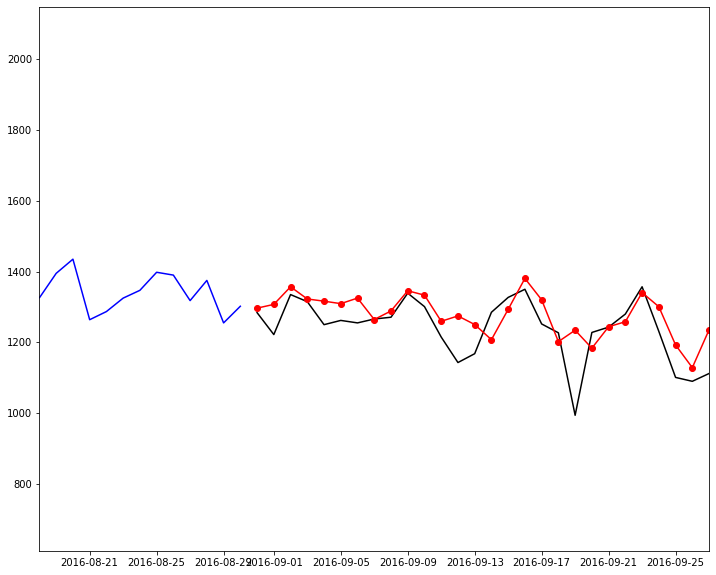

In [42]:
plt.figure(figsize=(12, 10))
plt.plot(NYcrime5[NYcrime5.index < 243].Datetime, y_train, color='blue')
plt.plot(NYcrime5[NYcrime5.index >= 243].Datetime, y_test, color='black')
plt.plot(NYcrime5[NYcrime5.index >= 243].Datetime, fcsari, color='red', marker='o')
plt.xlim(NYcrime5[NYcrime5.index == 230].Datetime,NYcrime5[NYcrime5.index == 270].Datetime)

In [43]:
res.aic

3329.643590854698

In [44]:
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  273
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1653.822
Date:                Wed, 29 Apr 2020   AIC                           3329.644
Time:                        18:08:35   BIC                           3369.307
Sample:                             0   HQIC                          3345.567
                                - 273                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6849      0.125     -5.470      0.000      -0.930      -0.439
ar.L2         -1.0035      0.081    -12.459      0.000      -1.161      -0.846
ar.L3         -0.5502      0.130     -4.233      0.0